# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

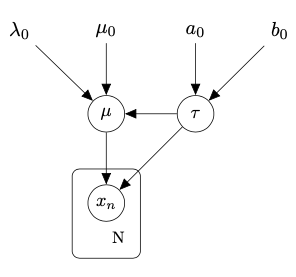

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [51]:
import numpy as np
def generate_data(mu, tau, N):
  '''
    Generate Gaussian distributed datasets of size N with 
    mean mu and precision tau
  '''
  sigma = 1/np.sqrt(tau)
  X = np.random.normal(mu, sigma, N)
  return X


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



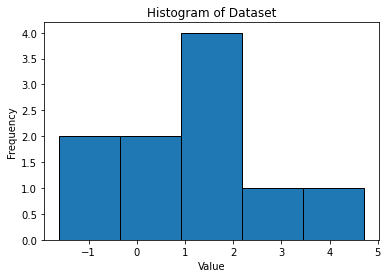

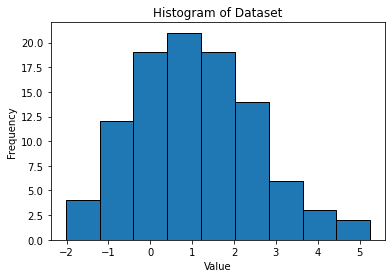

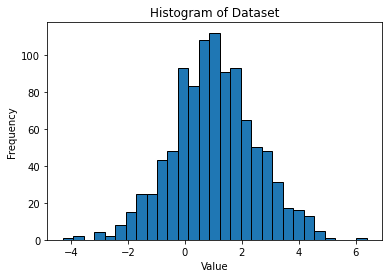

In [52]:
import matplotlib.pyplot as plt

mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
def PlotHistogram(X):
  plt.hist(X, bins='auto', edgecolor='black')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title('Histogram of Dataset')

  plt.show()

PlotHistogram(dataset_1)
PlotHistogram(dataset_2)
PlotHistogram(dataset_3)


### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [53]:
def ML_est(data):
  mu_ml = np.mean(data)
  N = len(data)
  sum = 0
  for x in data:
    sum += (x-mu)**2
  sample_variance = sum / N
  tau_ml = 1/sample_variance

  return mu_ml, tau_ml

print(ML_est(dataset_1)) 
print(ML_est(dataset_2)) 
print(ML_est(dataset_3)) 
#mu_ml is mean of data
#tau_ml is reciprocal of sample variance 

(1.2609804727425804, 0.375813674262337)
(1.077129400862253, 0.4750131798758166)
(1.0300946330314913, 0.4604777327481644)


### ***Question 1.3.14:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [54]:
# prior parameters
mu_0 = 1.5
lambda_0 = 1
a_0 = 1
b_0 = 2

Continue with a helper function that computes ELBO:


In [55]:
# from scipy.stats import gamma, norm
import math
from scipy.special import digamma #, gamma
from math import gamma, log
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here
  E_ln_tau = digamma(a_N) - np.log(b_N)
  E_tau = a_N / b_N
  E_mu = mu_N
  E_mu2 = mu_N**2 + 1 / lambda_N
  N = len(D)

  term1 = E_ln_tau * (N/2 + 1/2 + a_0 - 1)
  sum = 0
  for x in D:
    sum += x**2 - 2*x*E_mu + E_mu2
  
  term2 = -E_tau * (0.5 * sum + 0.5 * (E_mu2 - 2*mu_0*E_mu * mu_0**2) + b_0)
  
  term3 = -N/2 * np.log(2*math.pi) + a_0 * np.log(b_0) - log(gamma(a_0)) - 0.5 * np.log(lambda_N) + 0.5

  term4 = a_N - np.log(b_N) + np.log(gamma(a_N)) + (1 - a_N) * digamma(a_N)

  elbo = term1 + term2 + term3 + term4
  
  return elbo


Now, implement the CAVI algorithm:

In [56]:
import numpy as np
import math
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  delta_stop = 0.0001
  delta = math.inf
  initial_guess_exp_tau = a_0 / b_0
  elbos = []
  N = len(D)
  x_mean = np.mean(D)
  a_N = a_0
  b_N = b_0
  lambda_N = lambda_0

  # CAVI iterations ...
  # save ELBO for each iteration, plot them afterwards to show convergence
  while delta > delta_stop:
    E_tau = a_N / b_N
    lambda_N_old = lambda_N 
    mu_N = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
    lambda_N = (lambda_0 + N) * E_tau
    
    elbos.append(compute_elbo(D,a_0,b_0,mu_0,lambda_0,a_N,b_N,mu_N,lambda_N))

    E_mu = mu_N
    E_mu2 = 1/lambda_N + mu_N**2
    b_N_old = b_N
    a_N = a_0 + N/2
    sum = 0
    for x in D:
      sum += x**2 - 2*x*E_mu + E_mu2
    
    b_N = b_0 + 0.5 * sum + (lambda_0 / 2) * (E_mu2 - 2*mu_0*E_mu + mu_0**2)

    elbos.append(compute_elbo(D,a_0,b_0,mu_0,lambda_0,a_N,b_N,mu_N,lambda_N))

    delta = max(math.fabs(lambda_N - lambda_N_old), math.fabs(b_N - b_N_old))

  return a_N, b_N, mu_N, lambda_N, elbos

### ***Question 1.3.15:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [57]:
from scipy.special import gamma
import scipy
import mpmath

def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0, mu, tau):
  N = len(D)
  beta = b_0 + 0.5 * np.sum(D**2) + 0.5 * lambda_0 * mu_0**2 - ((lambda_0 * mu_0 + np.sum(D))**2) / (2 * (N + lambda_0))
  
  alpha = a_0 + N / 2
  l = N + lambda_0
  m = ((lambda_0 * mu_0) + np.sum(D)) / (N + lambda_0)

  # p = (beta**alpha * np.sqrt(l)) / (scipy.special.gamma(alpha) * np.sqrt(2*np.pi)) * (tau**(alpha - 1)) * math.exp(-beta*tau) * math.exp(-l*tau*((mu - m)**2) / 2)
  p = (mpmath.power(beta,alpha) * np.sqrt(l)) / (mpmath.gamma(alpha) * np.sqrt(2*np.pi)) * (mpmath.power(tau,(alpha - 1))) * mpmath.exp(-beta*tau) * mpmath.exp(-l*tau*((mu - m)**2) / 2)

  return p

In [58]:
def Gaussian(x, mu, var):        
  q = 1/(np.sqrt(var * 2*math.pi)) * math.exp(-0.5*((x-mu)/np.sqrt(var))**2)
  return q

In [59]:
def Gamma(x,a,b):
  # q = (x**(a-1)*math.exp(-b*x)*b**a) / scipy.special.gamma(a)
  q = (mpmath.power(x,(a-1))*mpmath.exp(-b*x)*mpmath.power(b,a)) / mpmath.gamma(a)
  return q

In [60]:
from scipy.stats import norm
import scipy
def computeCAVI(a_N, b_N, mu_N, lambda_N, mu, tau):
  # q = scipy.stats.gamma.pdf(tau, a_N, scale=b_N) * norm.pdf(mu, mu_N, 1/np.sqrt(lambda_N))
  q = Gaussian(mu,mu_N,1/lambda_N) * Gamma(tau,a_N, b_N)
  return q

In [61]:
def standardize(dist):
  magn = np.linalg.norm(dist)
  for i in range(dist.shape[0]):
    for j in range(dist.shape[1]):
      dist[i,j] /= magn
  return dist  

### ***Question 1.3.16:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



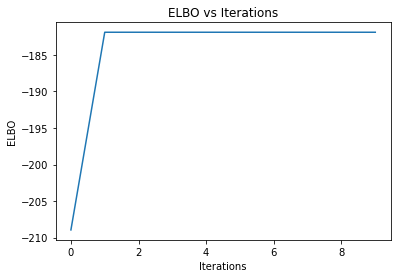

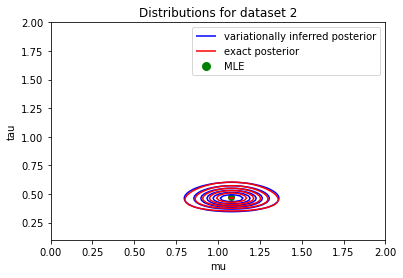

51.0 108.11122853504462
1.0813162384774782 47.64537479096254


In [62]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

mu_ml, tau_ml = ML_est(dataset_2)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
plt.plot(elbos)
plt.xlabel('Iterations')
plt.ylabel('ELBO')
plt.title('ELBO vs Iterations')
plt.show()
mu_vect = np.linspace(0,2,100)
tau_vect = np.linspace(0.1,2,100)

q = np.zeros((100,100))
p = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    q[i,j] = computeCAVI(a_N,b_N,mu_N,lambda_N,mu_vect[j], tau_vect[i])
    p[i,j] = compute_exact_posterior(dataset_2,a_0, b_0, mu_0, lambda_0, mu_vect[j], tau_vect[i])

# q = standardize(q)
# p = standardize(p)    

C1 = plt.contour(mu_vect, tau_vect, q, colors='blue')
C2 = plt.contour(mu_vect, tau_vect, p, colors='red')
plt.scatter(mu_ml, tau_ml, color='green', label='MLE')

h1,_ = C1.legend_elements()
h2,_ = C2.legend_elements()
h3 = Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='MLE')
plt.legend([h1[0], h2[0], h3], ['variationally inferred posterior', 'exact posterior', 'MLE'])

plt.xlabel("mu")
plt.ylabel("tau")
plt.title('Distributions for dataset 2')
plt.show()

print(a_N,b_N)
print(mu_N, lambda_N)



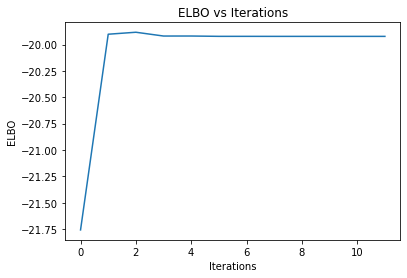

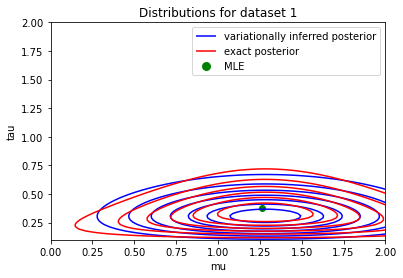

6.0 16.35259450089353
1.2827095206750732 4.036060743286496


In [63]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

mu_ml, tau_ml = ML_est(dataset_1)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_1, a_0, b_0, mu_0, lambda_0)
plt.plot(elbos)
plt.xlabel('Iterations')
plt.ylabel('ELBO')
plt.title('ELBO vs Iterations')
plt.show()
mu_vect = np.linspace(0,2,100)
tau_vect = np.linspace(0.1,2,100)

q = np.zeros((100,100))
p = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    q[i,j] = computeCAVI(a_N,b_N,mu_N,lambda_N,mu_vect[j], tau_vect[i])
    p[i,j] = compute_exact_posterior(dataset_1,a_0, b_0, mu_0, lambda_0, mu_vect[j], tau_vect[i])

# q = standardize(q)
# p = standardize(p)    

C1 = plt.contour(mu_vect, tau_vect, q, colors='blue')
C2 = plt.contour(mu_vect, tau_vect, p, colors='red')
plt.scatter(mu_ml, tau_ml, color='green', label='MLE')

h1,_ = C1.legend_elements()
h2,_ = C2.legend_elements()
h3 = Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='MLE')
plt.legend([h1[0], h2[0], h3], ['variationally inferred posterior', 'exact posterior', 'MLE'])

plt.xlabel("mu")
plt.ylabel("tau")
plt.title('Distributions for dataset 1')
plt.show()

print(a_N,b_N)
print(mu_N, lambda_N)



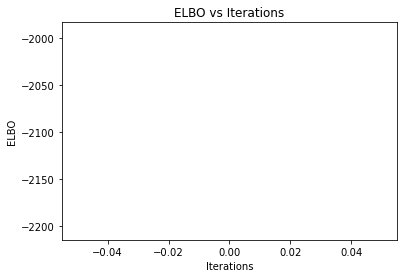

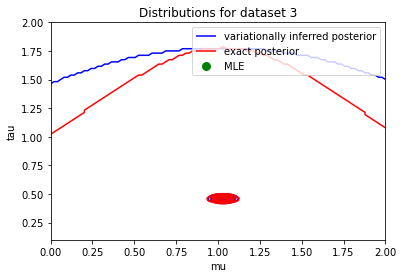

501.0 1088.5726864468677
1.0305640689625286 460.69592438197066
[-2099.077430623009, inf, inf, inf, inf, inf, inf, inf]


In [64]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

mu_ml, tau_ml = ML_est(dataset_3)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_3, a_0, b_0, mu_0, lambda_0)
plt.plot(elbos)
plt.xlabel('Iterations')
plt.ylabel('ELBO')
plt.title('ELBO vs Iterations')
plt.show()
mu_vect = np.linspace(0,2,100)
tau_vect = np.linspace(0.1,2,100)

q = np.zeros((100,100))
p = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    q[i,j] = computeCAVI(a_N,b_N,mu_N,lambda_N,mu_vect[j], tau_vect[i])
    p[i,j] = compute_exact_posterior(dataset_3,a_0, b_0, mu_0, lambda_0, mu_vect[j], tau_vect[i])

# q = standardize(q)
# p = standardize(p)    

C1 = plt.contour(mu_vect, tau_vect, q, colors='blue')
C2 = plt.contour(mu_vect, tau_vect, p, colors='red')
plt.scatter(mu_ml, tau_ml, color='green', label='MLE')

h1,_ = C1.legend_elements()
h2,_ = C2.legend_elements()
h3 = Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='MLE')
plt.legend([h1[0], h2[0], h3], ['variationally inferred posterior', 'exact posterior', 'MLE'])

plt.xlabel("mu")
plt.ylabel("tau")
plt.title('Distributions for dataset 3')
plt.show()

print(a_N,b_N)
print(mu_N, lambda_N)

print(elbos)
